In [1]:
%matplotlib ipympl

from onix.data_tools import get_experiment_data
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks

In [2]:
data_dict, headers = get_experiment_data(525310) # 525307, 525310
adc_interval = headers['adc_interval']
data_length = headers['data_length'] # get_data_length
repeats = headers['repeats'] # n_times_data
sample_rate = headers['sample_rate']

data = np.array([])
for i, data_array in data_dict.items():
    data = np.append(data, data_array)

times = np.linspace(0, 50*data_length*adc_interval, 50*data_length)

In [3]:
%%script false --no-raise-error
## averaging

N = 5000
avgs = np.zeros_like(data)
for i in range(data.size):
    avgs[i] = np.mean(data[max(i-N, 0):i+1])

In [4]:
# splitting data up into small chunks
split_width_s = 0.1 # [s]
split_width_samples = int(split_width_s*sample_rate)
split_avgs = np.reshape(data[:data.size-data.size%split_width_samples], (-1, split_width_samples))
# leaving out the last few samples so that the data can be split up into chunks with equal sizes

In [5]:
## fft
print(split_avgs.shape)
ffts = np.fft.rfft(split_avgs, axis=1)
fft_freqs = np.fft.rfftfreq(split_avgs.shape[1], 1/sample_rate)

(300, 10000)


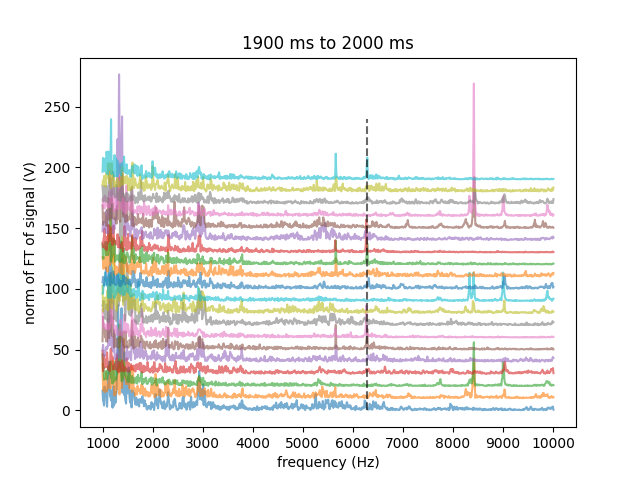

In [6]:
start_idx = np.argwhere(fft_freqs <= 1000)[-1][0]
end_idx = np.argwhere(fft_freqs > 10000)[0][0]+1

fig, ax1 = plt.subplots(1)
for i in range(20):  # ffts.shape[0]//2
    ax1.plot(fft_freqs[start_idx:end_idx], np.abs(ffts[i, start_idx:end_idx]) + 10 * i, alpha=0.6)#, color='black')
    ax1.set_xticks(fft_freqs[start_idx:end_idx:100])

    #peaks, properties = find_peaks(np.abs(ffts[i, start_idx:end_idx]), distance=100)# todo: change magic numbers
    #ax1.scatter(fft_freqs[start_idx+peaks], np.abs(ffts[i, start_idx+peaks]), color='red')
    
    ax1.set_xlabel('frequency (Hz)')
    ax1.set_ylabel('norm of FT of signal (V)')
    ax1.set_title(f'{100*i} ms to {100*(i+1)} ms')

ax1.vlines(x=6290, ymin=0, ymax=i*10+50, linestyle='dashed', color='black', alpha=0.6)
plt.show()

In [7]:
plt.close()

In [15]:
fft_freq_to_plot = 6270 # .000000000001 # 6290, 8450
amplitudes = ffts[:, fft_freqs == fft_freq_to_plot].flatten()
peaks, properties = find_peaks(np.abs(amplitudes), distance=0.6/split_width_s)

distances = np.abs(peaks - np.roll(peaks, 1))[1:]
print(f'mean of {round(np.mean(distances)*split_width_s*1000, 2)} ms, std of {round(np.std(distances)*split_width_s*1000, 2)} ms at frequency {fft_freq_to_plot} Hz')
distances

mean of 697.56 ms, std of 15.43 ms at frequency 6270 Hz


array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [9]:
%%script false --no-raise-error
"""
split width: characteristic frequency in Hz (mean of intervals between consecutive peaks in ms, standard deviation of the same in ms)
10ms: 5600 (695.81, 26.26), 6300 (697.14, 29.22), 8400 (698.33, 45.46), 9000 (697.38, 31.10)
25ms: 5680 (714.02, 80.4), 6280 (697.02, 26.84), 8440 (700, 55.37), 9000 (697.02, 19.06)
50ms: 5660 (697.62, 34.42), 6260 (697.56, 15.43), 8420 (697.62, 40.76), 9000 (697.62, 44.92)
100ms: 5660 Hz (697.62, 40.76), 6270 (697.56, 15.43), 8420 (697.62, 40.76), 9000 (697.62, 55.58)
"""

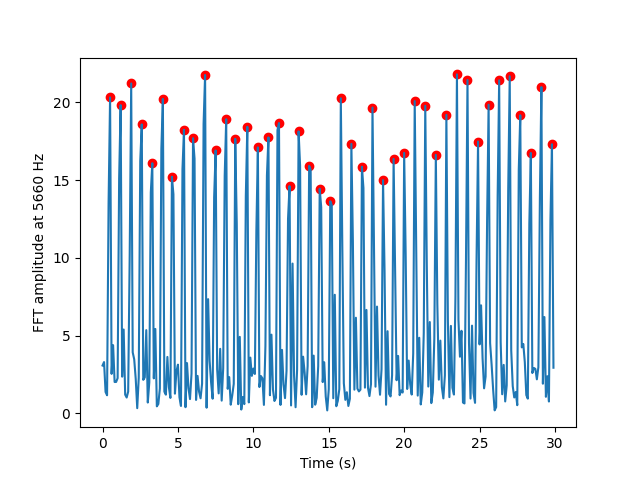

In [10]:
fig, ax1 = plt.subplots()

ax1.plot(np.arange(len(amplitudes)) * split_width_s, np.abs(amplitudes))

ax1.scatter(np.arange(len(amplitudes))[peaks] * split_width_s, np.abs(amplitudes)[peaks], color='red')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel(f"FFT amplitude at {fft_freq_to_plot} Hz")
plt.show()

In [11]:
%%script false --no-raise-error
characteristic_freqs = [1390, 6270, 9000] #, 6290, 8450]
peaks_f = {}
x = []
for f in characteristic_freqs:
    amplitudes = ffts[:, fft_freqs == f].flatten()
    peaks, properties = find_peaks(np.abs(amplitudes), distance=6)
    peaks_f[f] = peaks

for peak in peaks_f[characteristic_freqs[0]]:
    in_all = True
    for f in characteristic_freqs[1:]:
        in_all = (in_all) and (peak in peaks_f[f])
    if in_all:
        x.append(peak)

fig, ax1 = plt.subplots()
for f in characteristic_freqs[0:]:
    amplitudes = ffts[:, fft_freqs == fft_freq_to_plot].flatten()
    ax1.plot(np.arange(len(amplitudes)) * 0.1, np.abs(amplitudes), alpha=0.6, label=f"{f}")

ax1.scatter(np.arange(len(amplitudes))[x] * 0.1, np.abs(amplitudes)[x])
plt.legend()
plt.show()